In [7]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    
    dpi=80,
    facecolor="white",
    frameon=False,
)

/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/opt

In [2]:
l1 = sc.read_h5ad(
    filename="/home/sources/samples/L1/L1_L00_filtered.h5ad"
)
l2 = sc.read_h5ad(
    filename="/home/sources/samples/L2/L2_L00_filtered.h5ad"
)

# Check QC

In [3]:
# mitochondrial genes
l1.var["mt"] = l1.var_names.str.startswith("MT-")
l2.var["mt"] = l2.var_names.str.startswith("MT-")

# ribosomal genes
l1.var["ribo"] = l1.var_names.str.startswith(("RPS", "RPL"))
l2.var["ribo"] = l2.var_names.str.startswith(("RPS", "RPL"))


sc.pp.calculate_qc_metrics(
    l1, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
sc.pp.calculate_qc_metrics(
    l2, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
l1

AnnData object with n_obs × n_vars = 4422 × 68066
    obs: 'n_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

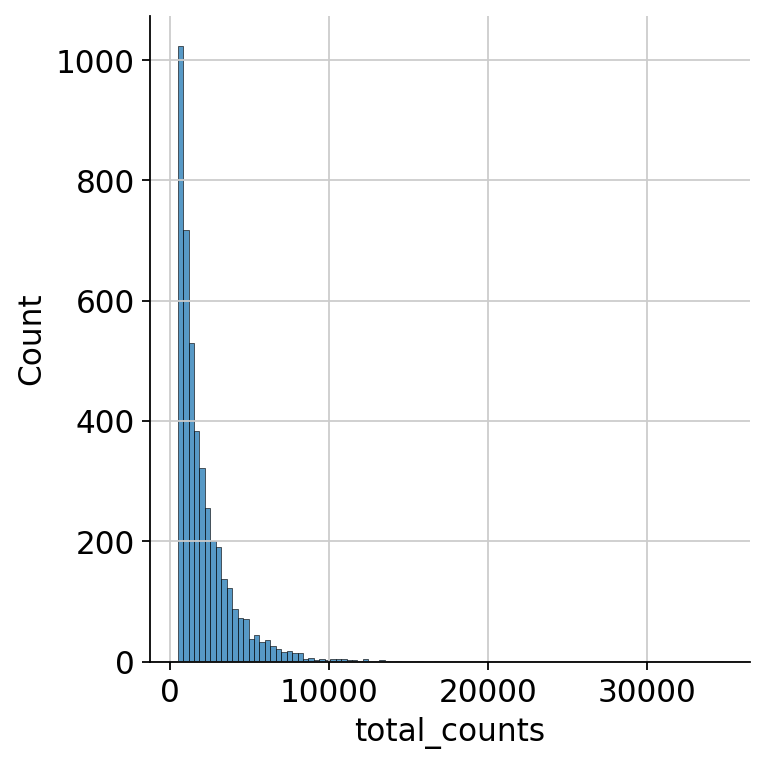

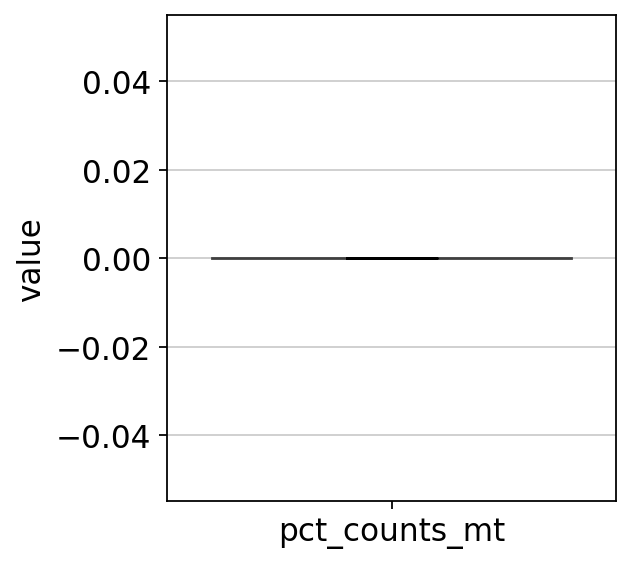

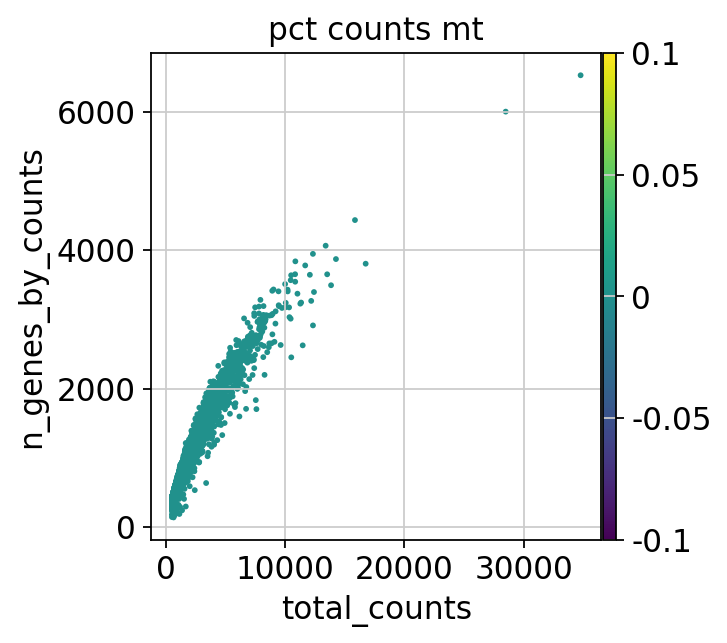

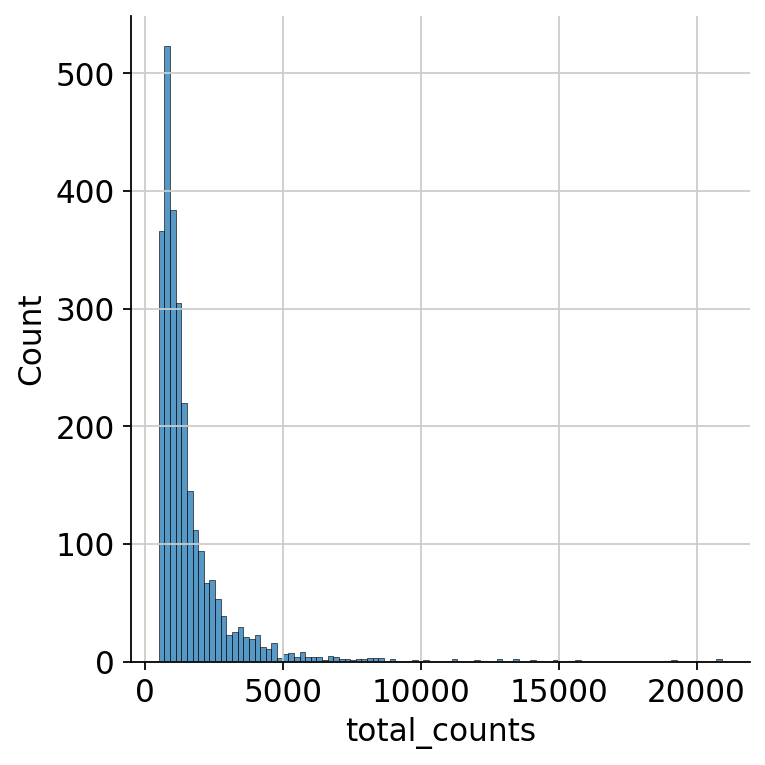

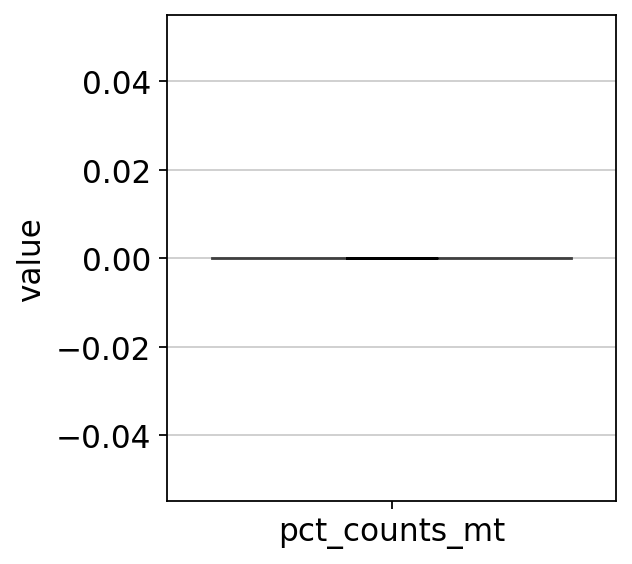

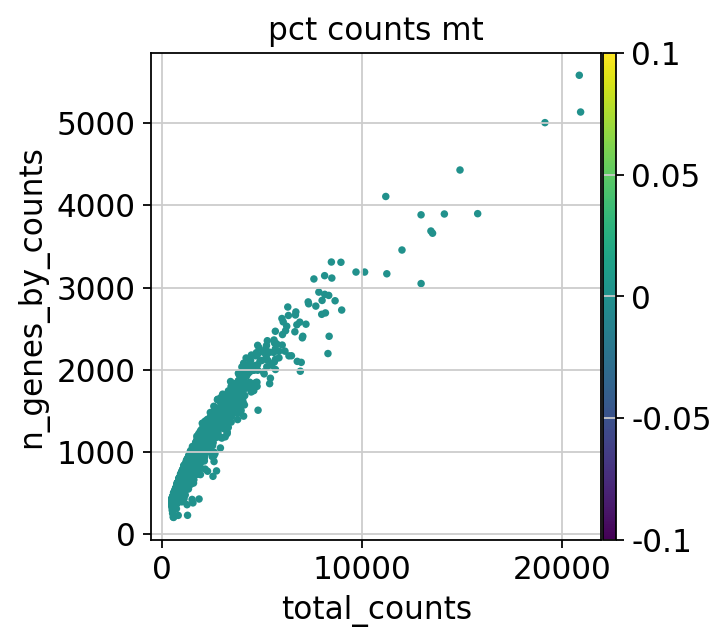

In [4]:
p1 = sns.displot(l1.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(l1, "pct_counts_mt")
p3 = sc.pl.scatter(l1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p4 = sns.displot(l2.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p5 = sc.pl.violin(l2, "pct_counts_mt")
p6 = sc.pl.scatter(l2, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Ambient RNA

In [2]:
import anndata2ri
import logging
import os

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [6]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [7]:
l1_raw = sc.read_10x_mtx(
    path="/home/sources/samples/L1/raw_cell_gene_matrix"
)
l1_tod = l1_raw.X.T
l2_raw = sc.read_10x_mtx(
    path="/home/sources/samples/L2/raw_cell_gene_matrix"
)
l2_tod = l2_raw.X.T

In [8]:
del l1_raw
del l2_raw

In [9]:
l1_pp = l1.copy()
sc.pp.normalize_per_cell(l1_pp)
sc.pp.log1p(l1_pp)
l2_pp = l2.copy()
sc.pp.normalize_per_cell(l2_pp)
sc.pp.log1p(l2_pp)

In [10]:
sc.pp.pca(l1_pp)
sc.pp.neighbors(l1_pp)
sc.tl.leiden(l1_pp, key_added="soupx_groups")
sc.pp.pca(l2_pp)
sc.pp.neighbors(l2_pp)
sc.tl.leiden(l2_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups_l1 = l1_pp.obs["soupx_groups"]
soupx_groups_l2 = l2_pp.obs["soupx_groups"]

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_168463/2418096638.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(l1_pp, key_added="soupx_groups")


In [11]:
del l1_pp
del l2_pp

In [12]:
cells_l1 = l1.obs_names
genes_l1 = l1.var_names
data_l1 = l1.X.T
cells_l2 = l2.obs_names
genes_l2 = l2.var_names
data_l2 = l2.X.T

In [13]:
%%R -i data_l1 -i l1_tod -i genes_l1 -i cells_l1 -i soupx_groups_l1 -o out_l1 

# specify row and column names of data
rownames(data_l1) = genes_l1
colnames(data_l1) = cells_l1
# ensure correct sparse format for table of counts and table of droplets
data_l1 <- as(data_l1, "sparseMatrix")
l1_tod <- as(l1_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(l1_tod, data_l1, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data_l1), est = rowSums(data_l1)/sum(data_l1), counts = rowSums(data_l1))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups_l1)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out_l1 = adjustCounts(sc, roundToInt = TRUE)

In [14]:
%%R -i data_l2 -i l2_tod -i genes_l2 -i cells_l2 -i soupx_groups_l2 -o out_l2 

# specify row and column names of data
rownames(data_l2) = genes_l2
colnames(data_l2) = cells_l2
# ensure correct sparse format for table of counts and table of droplets
data_l2 <- as(data_l2, "sparseMatrix")
l2_tod <- as(l2_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(l2_tod, data_l2, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data_l2), est = rowSums(data_l2)/sum(data_l2), counts = rowSums(data_l2))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups_l2)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out_l2 = adjustCounts(sc, roundToInt = TRUE)

In [15]:
l1.layers["counts"] = l1.X
l1.layers["soupX_counts"] = out_l1.T
l1.X = l1.layers["soupX_counts"]
l2.layers["counts"] = l2.X
l2.layers["soupX_counts"] = out_l2.T
l2.X = l2.layers["soupX_counts"]

In [16]:
print(f"Total number of genes: {l1.n_vars}")

# Min 3 cells - filters out 0 count genes
sc.pp.filter_genes(l1, min_cells=3)
print(f"Number of genes after cell filter: {l1.n_vars}")

Total number of genes: 68066
Number of genes after cell filter: 16463


In [17]:
print(f"Total number of genes: {l2.n_vars}")

# Min 3 cells - filters out 0 count genes
sc.pp.filter_genes(l2, min_cells=3)
print(f"Number of genes after cell filter: {l2.n_vars}")

Total number of genes: 68066
Number of genes after cell filter: 15858


In [ ]:
#l1.write_h5ad('/home/sources/L1_preprocessed.h5ad')
#l2.write_h5ad('/home/sources/L2_preprocessed.h5ad')

# Doublets

In [9]:
l1 = sc.read_h5ad(
    filename="/home/sources/analysis/L1_preprocessed.h5ad"
)
l2 = sc.read_h5ad(
    filename="/home/sources/analysis/L2_preprocessed.h5ad"
)

In [ ]:
# %%R
# BiocManager::install("scater")
# BiocManager::install("scDblFinder")

In [5]:
%%R
library(BiocParallel)
library(Seurat)
library(scater)
library(scDblFinder)
library(SingleCellExperiment)


In [10]:
l1_mat = l1.X.T
l2_mat = l2.X.T

In [11]:
%%R -i l1_mat -o doublet_score_l1 -o doublet_class_l1

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=l1_mat),
    ) 
)
doublet_score_l1 = sce$scDblFinder.score
doublet_class_l1 = sce$scDblFinder.class

In [12]:
%%R -i l2_mat -o doublet_score_l2 -o doublet_class_l2

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=l2_mat),
    ) 
)
doublet_score_l2 = sce$scDblFinder.score
doublet_class_l2 = sce$scDblFinder.class

In [13]:
l1.obs["scDblFinder_score"] = doublet_score_l1
l1.obs["scDblFinder_class"] = doublet_class_l1
l1.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    4118
doublet     304
Name: count, dtype: int64

In [14]:
l2.obs["scDblFinder_score"] = doublet_score_l2
l2.obs["scDblFinder_class"] = doublet_class_l2
l2.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    2500
doublet     141
Name: count, dtype: int64

In [15]:
l1.write_h5ad('/home/sources/analysis/L1_preprocessed.h5ad')
l2.write_h5ad('/home/sources/analysis/L2_preprocessed.h5ad')

# Normalization

In [44]:
from scipy.sparse import csr_matrix, issparse
import matplotlib.pyplot as plt

In [41]:
scales_counts_l1 = sc.pp.normalize_total(l1, target_sum=None, inplace=False)
scales_counts_l2 = sc.pp.normalize_total(l2, target_sum=None, inplace=False)

# log1p transform
l1.layers["log1p_norm"] = sc.pp.log1p(scales_counts_l1["X"], copy=True)
l2.layers["log1p_norm"] = sc.pp.log1p(scales_counts_l2["X"], copy=True)

# analytic pearson
analytic_pearson_l1 = sc.experimental.pp.normalize_pearson_residuals(l1, inplace=False)
analytic_pearson_l2 = sc.experimental.pp.normalize_pearson_residuals(l2, inplace=False)

l1.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson_l1["X"])
l2.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson_l2["X"])

In [ ]:
#l1.write_h5ad('/home/sources/L1_norm.h5ad')
#l2.write_h5ad('/home/sources/L2_norm.h5ad')

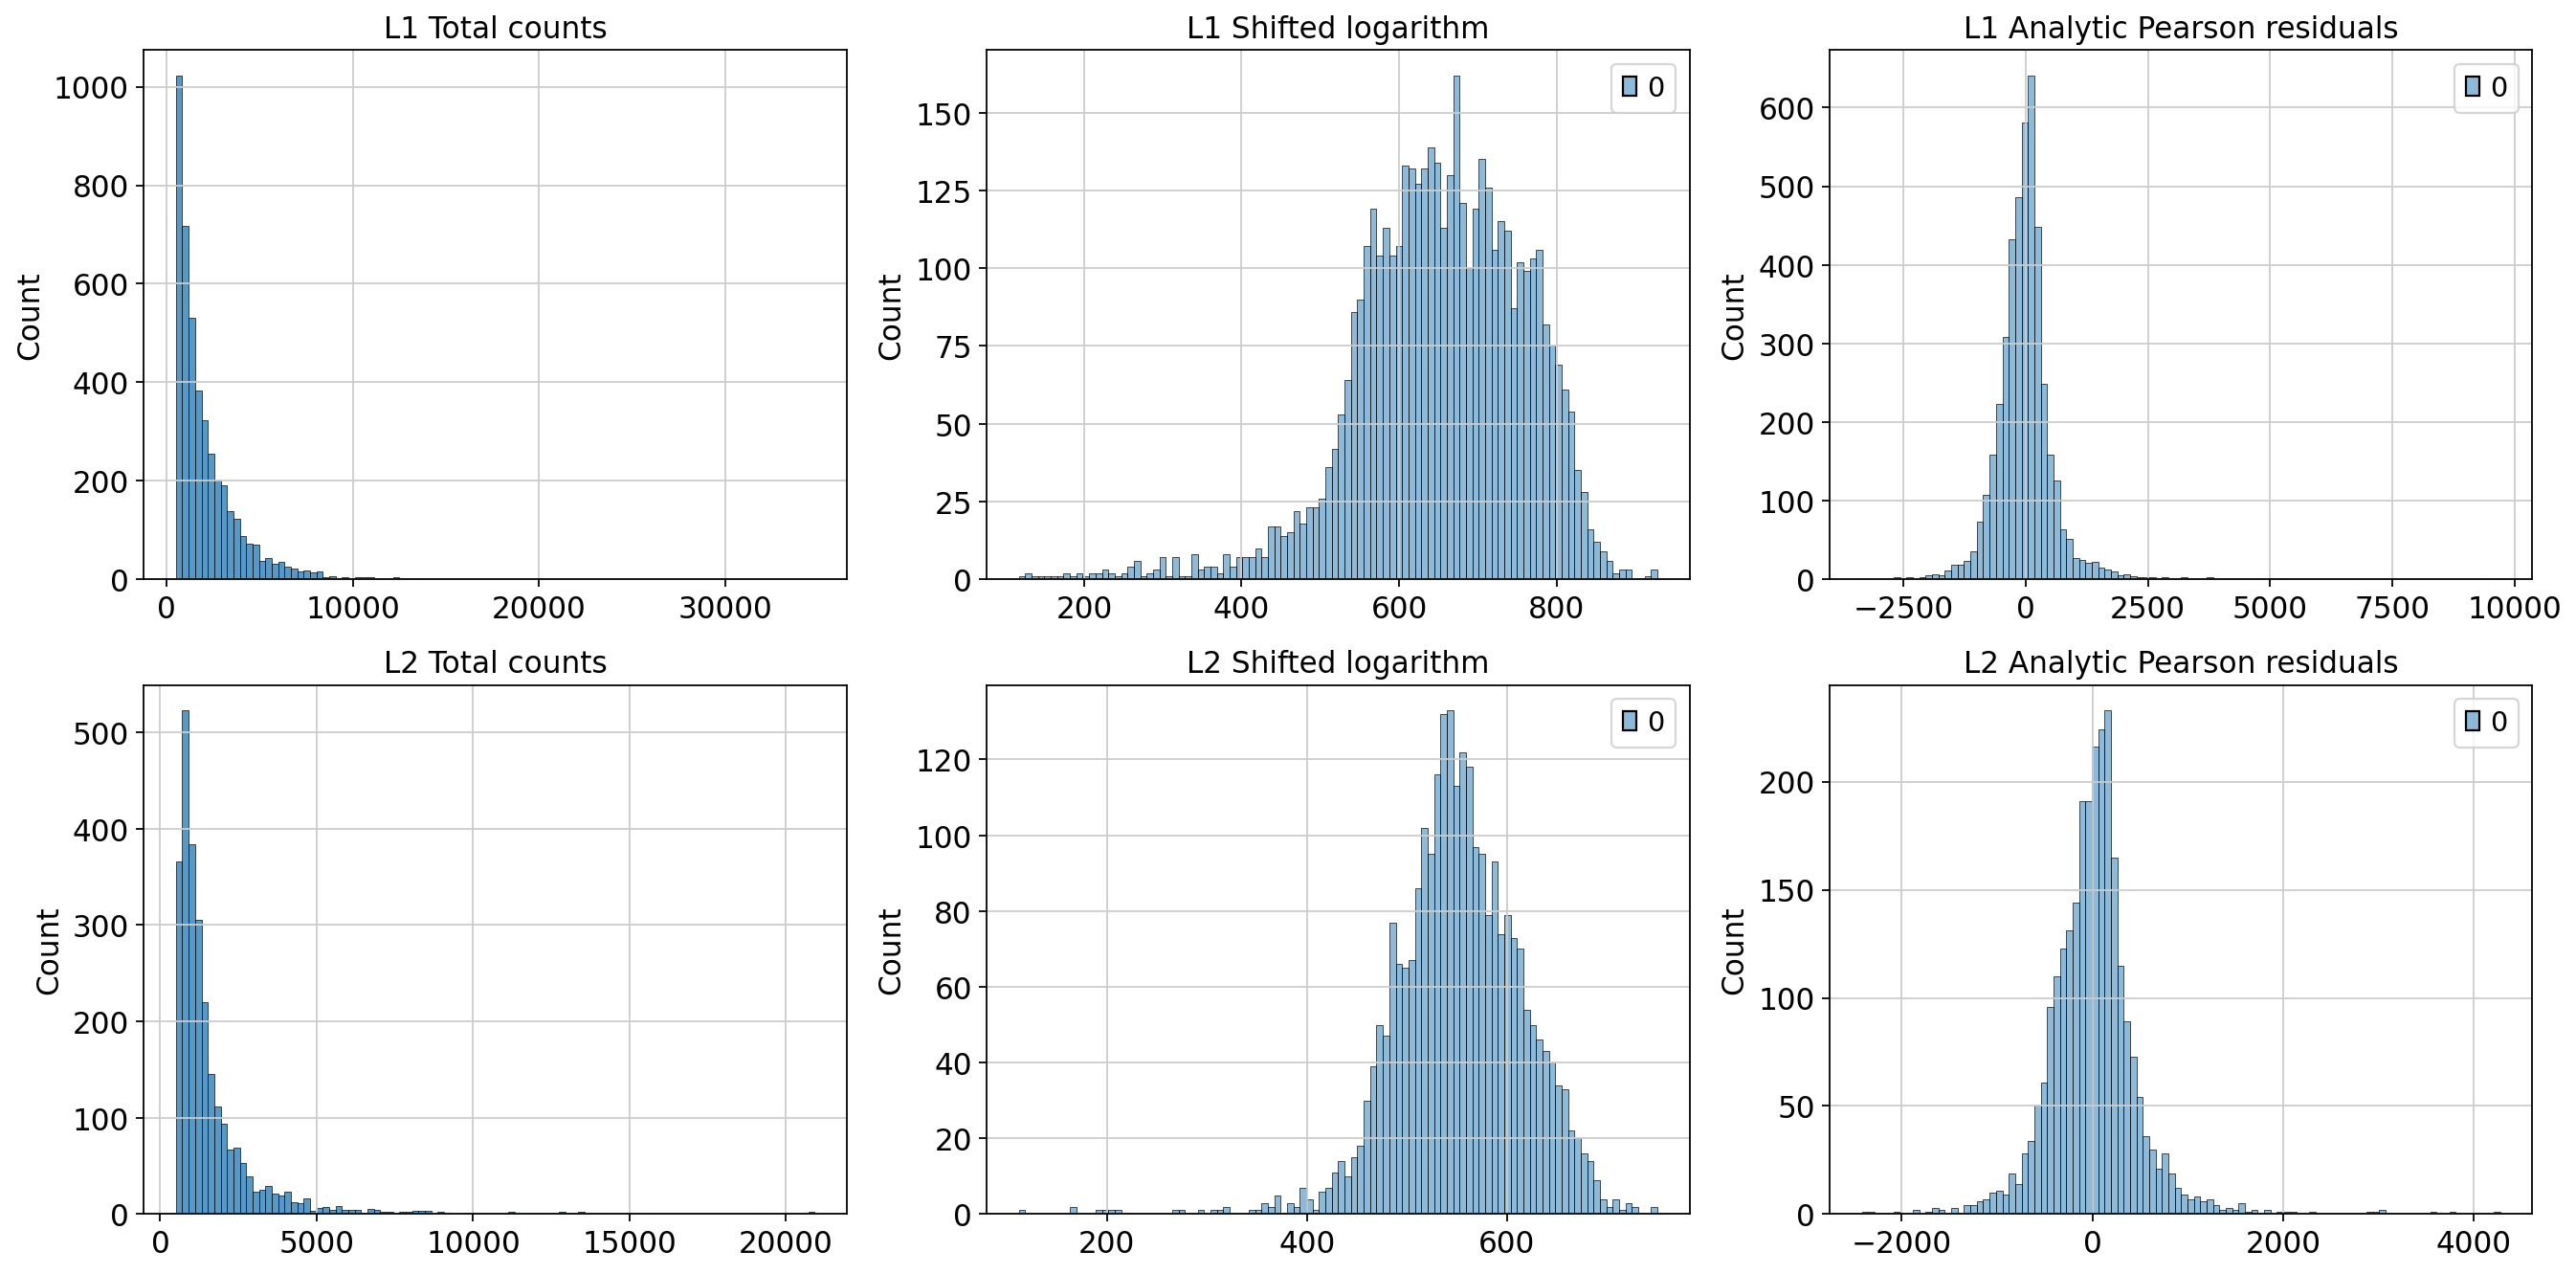

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

p1 = sns.histplot(l1.obs["total_counts"], bins=100, kde=False, ax=axes[0][0])
axes[0][0].set_title("L1 Total counts")
axes[0][0].set_xlabel('')

p2 = sns.histplot(
    l1.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[0][1]
)
axes[0][1].set_title("L1 Shifted logarithm")

p3 = sns.histplot(
    l1.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[0][2]
)
axes[0][2].set_title("L1 Analytic Pearson residuals")

p4 = sns.histplot(l2.obs["total_counts"], bins=100, kde=False, ax=axes[1][0])
axes[1][0].set_title("L2 Total counts")
axes[1][0].set_xlabel('')

p5 = sns.histplot(
    l2.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1][1]
)
axes[1][1].set_title("L2 Shifted logarithm")

p6 = sns.histplot(
    l2.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1][2]
)
axes[1][2].set_title("L2 Analytic Pearson residuals")
plt.show()